<center><h1> Homework 3 </h1></center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rootfinder as rtf
from scipy.integrate import odeint

1.

In [3]:
hbar = 1.05e-34
m = 9.1e-31
a = 1e-11
Vscale = 1.6e-19
lscale = hbar/a / np.sqrt(Vscale*m) # taking hbar**2/m = 1, 1eV = 1

class QM(object):
    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
    
        """right hand side of the differential equation"""
        u = uv[1]
        v = 2*(Potential(x) - self.E)*uv[0]
        return np.ravel(np.array([u, v]))

Harmonic oscillator
Energy found: 137.58739eV
Energy found: 412.76215eV	Spacing: 275.17477eV
Energy found: 687.93693eV	Spacing: 275.17477eV
Energy found: 963.11170eV	Spacing: 275.17477eV
Energy found: 1238.28647eV	Spacing: 275.17477eV
Energy found: 1513.46125eV	Spacing: 275.17478eV
Energy found: 1788.63605eV	Spacing: 275.17481eV
Energy found: 2063.81103eV	Spacing: 275.17498eV
Energy found: 2338.98722eV	Spacing: 275.17619eV
Energy found: 2614.17102eV	Spacing: 275.18380eV
Anharmonic oscillator
Energy found: 138.14994eV
Energy found: 415.56007eV	Spacing: 277.41013eV
Energy found: 695.16634eV	Spacing: 279.60627eV
Energy found: 976.92142eV	Spacing: 281.75508eV
Energy found: 1260.78054eV	Spacing: 283.85911eV
Energy found: 1546.70124eV	Spacing: 285.92071eV
Energy found: 1834.64327eV	Spacing: 287.94203eV
Energy found: 2124.56827eV	Spacing: 289.92500eV
Energy found: 2416.44005eV	Spacing: 291.87178eV
Energy found: 2710.22445eV	Spacing: 293.78440eV


Text(0.5, 1.0, 'Energy Levels')

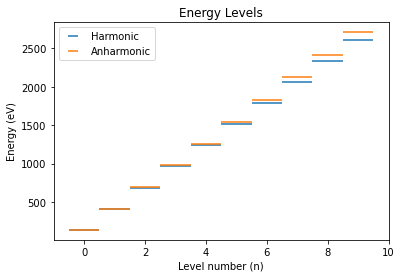

In [4]:
boundary = 10.0/lscale

def harmonic(x):
        # harmonic oscillator potential
        V0 = 50
        return V0 * (x*lscale)**2
    
def anharmonic(x):
        # anharmonic oscillator potential
        V0 = 50
        V1 = 0.1
        return V0 * (x*lscale)**2 + V1 * (x*lscale)**4

def match(En):
    p_up = QM(E = En, npoints = 1000, x_start = -boundary)
    p_down = QM(E = En, npoints = 1000, x_start = boundary)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

def find_energies(num_states):
    E_SM = []
    i = 0
    E1 = 100
    dE = 10
    while (i < num_states):

        if match(E1)*match(E1 + dE) < 0 :  # bracket E
            # find the energy
            E = rtf.bisect(match, E1, E1+dE, 1e-12)
            print('Energy found: %.5feV'%(E)+('\tSpacing: %.5feV'%(E-E_SM[-1]) if i>0 else ''))
            E_SM.append(E)
            i += 1

        E1 += dE
    return E_SM

print('Harmonic oscillator')
Potential = harmonic # global variable describing potential
E_harm = find_energies(10)
print('Anharmonic oscillator')
Potential = anharmonic
E_anharm = find_energies(10)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(range(10), E_harm, xerr=0.5, linestyle='none', label='Harmonic')
ax.errorbar(range(10), E_anharm, xerr=0.5, linestyle='none', label='Anharmonic')
ax.set_xlabel('Level number (n)')
ax.set_ylabel('Energy (eV)')
ax.legend()
ax.set_title('Energy Levels')

The spacing between energy levels of the harmonic oscillator is uniform at about 275.175eV, while the spacing increases with increasing level number for the anharmonic oscillator.

Length Scale: 1 scale unit = 27.517476963950354a


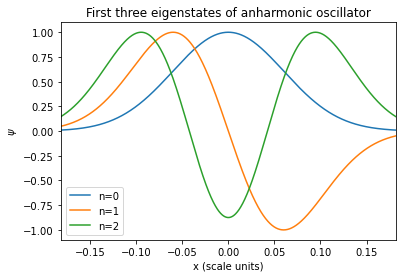

In [8]:
print('Length Scale: 1 scale unit =', str(lscale)+'a')
for i in range(3):
    p_up = QM(E = E_anharm[i], npoints=1002, x_start = -boundary, x_end = boundary/1000) # cannot match at zero for odd n
    p_down = QM(E = E_anharm[i], npoints=1000, x_start = boundary, x_end = boundary/1000)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()
    
    scale = p_up.uv_end[0]/p_down.uv_end[0]
    psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
    xa = np.linspace(-boundary, boundary, 2001, endpoint=True)
    plt.plot(xa, psi_x/np.amax(psi_x), label='n='+str(i))

plt.xlim(-boundary/2, boundary/2)
# plt.plot(xa, np.vectorize(Potential)(xa)/1312.5, color='k')
plt.title('First three eigenstates of anharmonic oscillator')
plt.xlabel('x (scale units)')
plt.ylabel('$\\psi$')
plt.legend()
plt.show()

2. a)

In [9]:
def invDel2(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # this update fixes V along edges = 0
        Vnew[1:-1, 1:-1] = (V[1:-1,2:] + V[1:-1,:-2] + V[2:,1:-1] \
                + V[:-2,1:-1] + (dx*dx)*b[1:-1,1:-1])/4
        
        # enforce the boundary conditions at every update
        Vnew = boundary(Vnew)
        
        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for more complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

In [10]:
def square_cylinder(phi):
    phi[10:15,10] = 1
    phi[15,10:15] = 1
    phi[10,11:16] = 1
    phi[11:16,15] = 1
    # Edges are already set to zero by invDel2
    return phi

rho = np.zeros((26,26))
X,Y = np.meshgrid(0.5*np.arange(-25, 26, 2), 0.5*np.arange(-25, 26, 2))
phi = invDel2(rho, square_cylinder, dx=1.0)

<ipython-input-12-b714d99142e4>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m0 = ax0.pcolormesh(X, Y, phi)


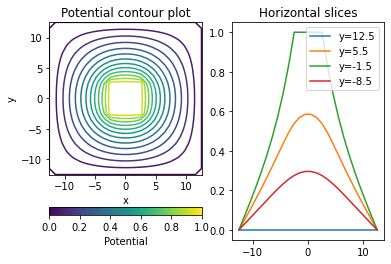

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(121)

ax0 = plt.Axes(plt.Figure(), (0,0,1,1)) # dummy axes to set up mapping for colorbar
m0 = ax0.pcolormesh(X, Y, phi)

ax1.contour(X,Y,phi, levels=15)
cbar = fig.colorbar(m0, orientation='horizontal', label="Potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Potential contour plot")

ax2 = fig.add_subplot(122)
ax2.set_title("Horizontal slices")

for i in range(0, 26, 7):
    ax2.plot(X[i], phi[i], label='y='+str(12.5-i))
ax2.legend()

b)

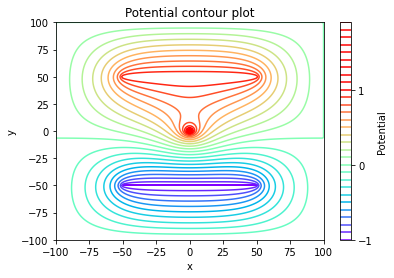

<ipython-input-57-935d0960b8c5>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.colorbar(plt.pcolormesh(X, Y, Emag, cmap='Reds', vmax=2*np.median(Emag)), label='Magnitude')


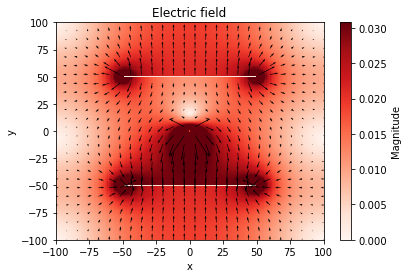

In [57]:
def parallel_plate(phi):
    phi[50,50:151] = -1
    phi[150,50:151] = 1
    return phi

rho = np.zeros((201,201))
rho[100,100] = 2 # point charge
X,Y = np.meshgrid(np.arange(-100,101), np.arange(-100,101))
phi = invDel2(rho, parallel_plate, dx=1.0)

plt.title('Potential contour plot')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(plt.contour(X, Y, phi, cmap='rainbow', levels=30, vmin=-1.0, vmax=1.0), ticks=[-1,0,1], label='Potential')
plt.show()

EY,EX = -1*np.array(np.gradient(phi))
Emag = np.sqrt(EX**2+EY**2)
plt.title('Electric field')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(plt.pcolormesh(X, Y, Emag, cmap='Reds', vmax=2*np.median(Emag)), label='Magnitude')
plt.quiver(X[::8,::8], Y[::8,::8], EX[::8,::8], EY[::8,::8], units='width')

The contours close to the positive plate tend to warp around the point charge, while the ones close to the negative plate tend to avoid it by receding back. The highest potential is obviously found close to the point charge, where it increases unbounded. But as the point charge moves toward the positive plate, the equipotential contours surrounding it are distorted, bulging in the direction of the plate. When the charge is closer to the negative plate, the distortion is the opposite i.e. bulging away from the plate, with the contours being very closely packed on the side nearer the plate.